In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf

from datetime import datetime

from mizani.breaks import date_breaks
from mizani.formatters import date_format

from plotnine import *

import matplotlib.pyplot as plt
# Set Matplotlib font size
plt.rcParams.update({'font.size': 14})

pd.set_option("display.float_format", lambda f: f"{f:,.2f}")

In [2]:
%matplotlib inline

## Buying: Constants

In [3]:
interest_rate = 0.065  # 6.5% mortgage interest rate
cost = 800_000 # USD
hoa = 200  # monthly HOA
down_payment = cost * 0.2  # 20% down payment
principal = cost - down_payment
buying_fees = principal * 0.04  # 4% of the principal is buying fees

## Buying: Calculated Values

In [58]:
loan_period_in_years = 15
loan_period_in_months = 12 * loan_period_in_years

full_time_period_in_years = 30
full_time_period_in_months = full_time_period * 12

monthly_interest_rate = interest_rate / 12

mortgage_payment = float(npf.pmt(monthly_interest_rate, loan_period_in_months, principal))
mortgage_payment

-5575.08713790314

## Renting: Constants

In [59]:
rent = 3_000

## Market "Simulation"

In [60]:
seed = 42 # because why not 42?
np.random.seed(seed)

## Stock Appreciation Parameters

- `mu_stock`: on average, +11% per annum
- `sigma_stock`: on average, ±23% per annum

In [61]:
mu_stock = 0.1081
sigma_stock = 0.2267

## Home Appreciation Parameters

- `mu_home`: on average, +6% per annum growth
- `sigma_home`: on average, ±10% per annum

In [62]:
mu_home = 0.0572
sigma_home = 0.1042

Assumption is that stock appreciation is correlated with home appreciation. Probably reasonable.

In [63]:
corr_assumption = 0.5
# cov = rho * sigma_1 * ... * sigma_n
cov = corr_assumption * sigma_stock * sigma_home
cov

0.01181107

In [64]:
cov_mat = np.array([[sigma_stock ** 2, cov],
                    [cov, sigma_home ** 2]])
cov_mat

array([[0.05139289, 0.01181107],
       [0.01181107, 0.01085764]])

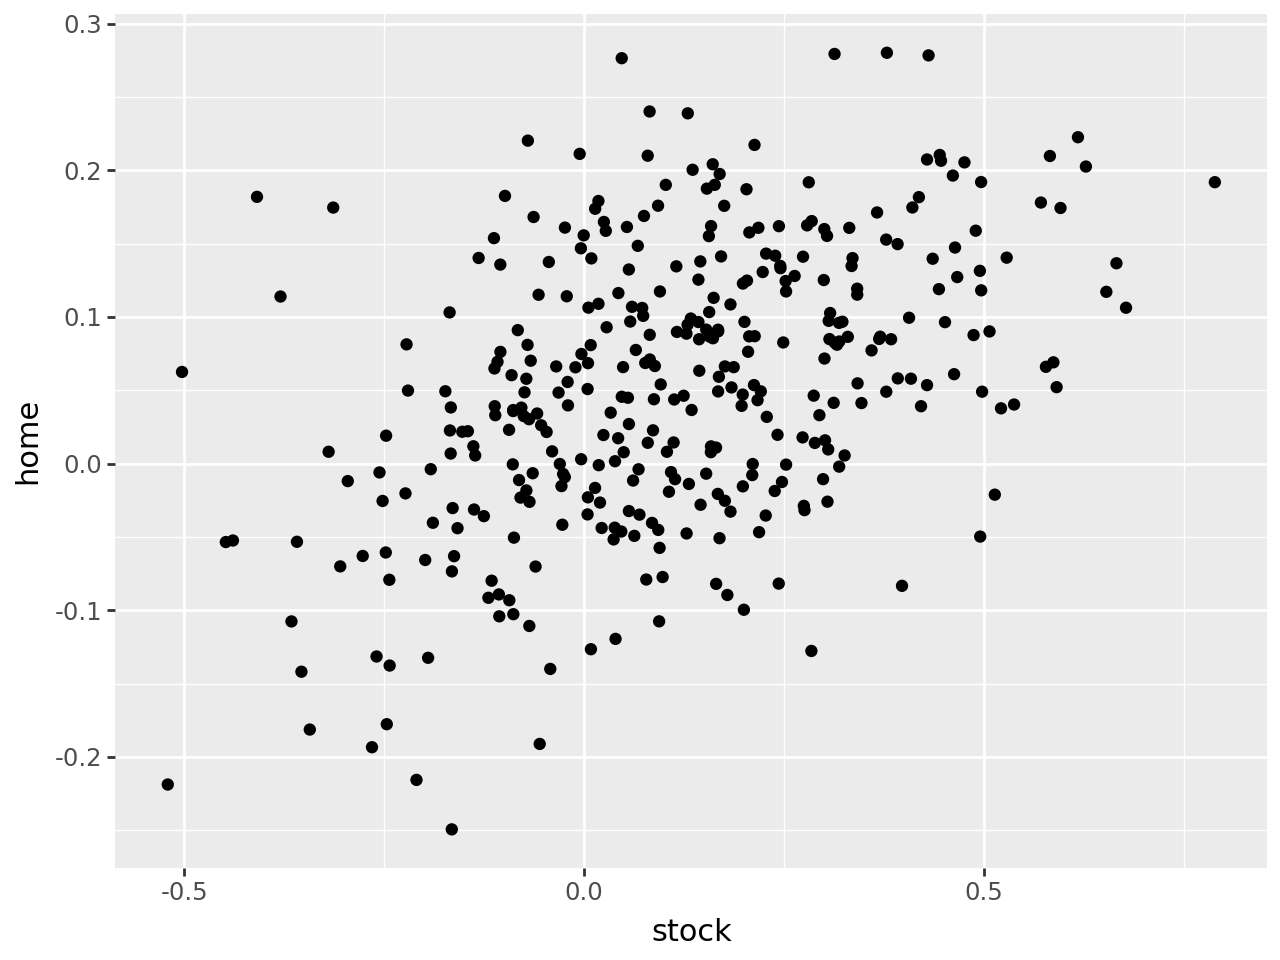

In [164]:
data = np.random.default_rng(seed).multivariate_normal(
    [mu_stock, mu_home],
    cov_mat,
    full_time_period_in_months,
    check_valid="raise",
)

cols = ["stock", "home"]
ggplot(pd.DataFrame(data, columns=cols), aes(*cols)) + geom_point()

In [66]:
returns_df = pd.DataFrame(data, columns=["stock_apprec", "home_apprec"])
returns_df

,stock_apprec,home_apprec
0,0.06,-0.05
1,-0.08,0.09
2,0.58,0.07
3,0.09,0.02
4,0.13,-0.01
...,...,...
355,0.10,0.12
356,0.34,0.12
357,0.18,-0.03
358,0.45,0.21


In [67]:
returns_df /= 12
returns_df

,stock_apprec,home_apprec
0,0.01,-0.00
1,-0.01,0.01
2,0.05,0.01
3,0.01,0.00
4,0.01,-0.00
...,...,...
355,0.01,0.01
356,0.03,0.01
357,0.02,-0.00
358,0.04,0.02


In [68]:
cumulative_returns = returns_df.add(1).cumprod().reset_index(names=["period"])

In [69]:
cumulative_returns

,period,stock_apprec,home_apprec
0,0,1.01,1.00
1,1,1.00,1.00
2,2,1.05,1.01
3,3,1.05,1.01
4,4,1.07,1.01
...,...,...,...
355,355,26.55,4.81
356,356,27.30,4.86
357,357,27.72,4.84
358,358,28.75,4.93


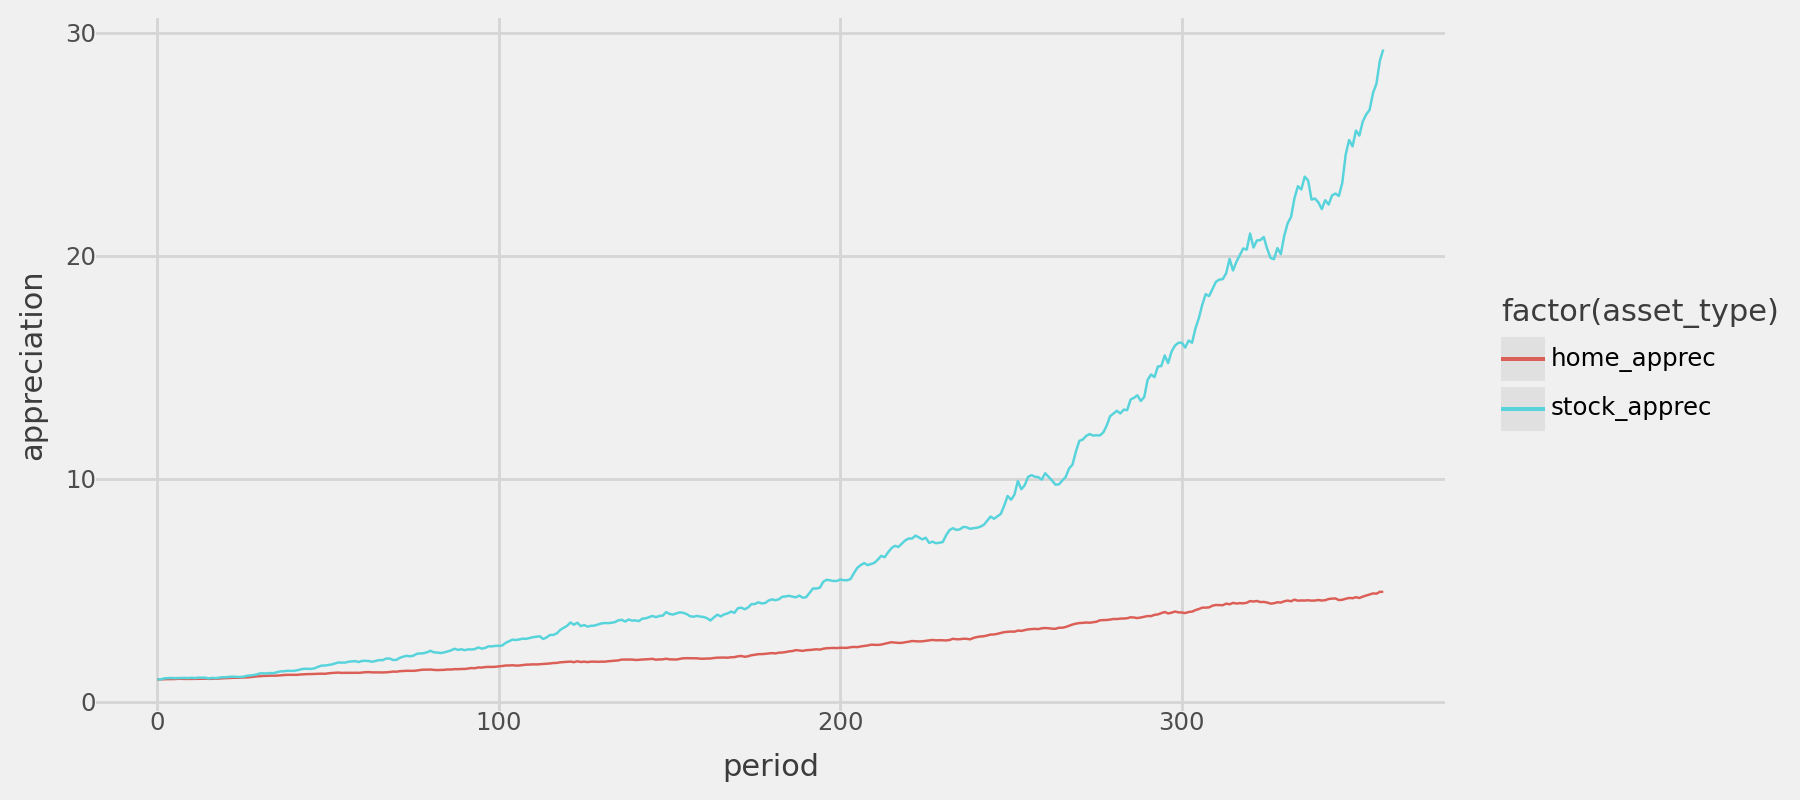

In [70]:
returns = pd.melt(
    cumulative_returns,
    id_vars="period",
    value_name="appreciation",
    var_name="asset_type",
)
(
    ggplot(returns, aes("period", "appreciation", color="factor(asset_type)"))
    + geom_line()
    + theme_538()
    + theme(figure_size=(9, 4))
)

In [71]:
home_perf = cumulative_returns.home_apprec
stock_perf = cumulative_returns.stock_apprec

## Buying Calculations

In [136]:
# costs
loan_period = np.arange(1, loan_period_in_months + 1, dtype="int64")
time_period = np.arange(1, full_time_period_in_months + 1, dtype="int64")
princ_paid = npf.ppmt(monthly_interest_rate, loan_period, loan_period_in_months, principal)
princ_paid = np.pad(princ_paid, (0, pad_length), constant_values=0)
int_paid = npf.ipmt(monthly_interest_rate, loan_period, loan_period_in_months, principal)
int_paid = np.pad(int_paid, (0, pad_length), constant_values=0)
hoa_paid = np.full(full_time_period_in_months, fill_value=hoa).cumsum()

In [137]:
home_val = cost * home_perf
bal_rem = principal + princ_paid.cumsum()
sale_fees = home_val * 0.07

## NC Wake County Tax Rate Details

Example: https://www.ncdor.gov/taxes-forms/property-tax/how-calculate-tax-bill

In [140]:
# 2024-2025 tax rate for wake county
# take the highest rate for max pessimalism: zebulon according to
# https://www.ncdor.gov/2024-2025taxrateseffectivetaxratespdf/open
wake_county_maximum_combined_effective_tax_rate = 0.010756
prop_taxes = (home_val * wake_county_maximum_combined_effective_tax_rate) / 12
prop_taxes

0       714.12
1       719.54
2       723.49
3       724.86
4       724.02
        ...   
355   3,448.84
356   3,483.11
357   3,473.61
358   3,534.52
359   3,532.21
Name: home_apprec, Length: 360, dtype: float64

In [141]:
reassessed = np.mod(time_period - 1, 8 * 12) == 0

Look into homestead exemptions

In [142]:
reassessed.size

360

In [143]:
monthly_prop_tax = prop_taxes.where(reassessed).ffill()

In [144]:
monthly_prop_tax

0       714.12
1       714.12
2       714.12
3       714.12
4       714.12
        ...   
355   2,708.10
356   2,708.10
357   2,708.10
358   2,708.10
359   2,708.10
Name: home_apprec, Length: 360, dtype: float64

In [145]:
prop_tax_paid = monthly_prop_tax.cumsum()
prop_tax_paid

0         714.12
1       1,428.24
2       2,142.37
3       2,856.49
4       3,570.61
         ...    
355   520,620.38
356   523,328.47
357   526,036.57
358   528,744.67
359   531,452.77
Name: home_apprec, Length: 360, dtype: float64

## Back to calcs …

In [146]:
date = pd.date_range(start=datetime.today().date(), periods=full_time_period_in_months, freq='MS')

In [147]:
monthly_ins_cost = 0.005 * home_val / 12  # insurance is 5% of the home value, might be overestimating
maint_fees = home_val * 0.01 / 12  # 1% average cost of ownership (maintenance, etc.)
pad_length = int(full_time_period_in_months * (loan_period_in_months / full_time_period_in_months))

In [206]:
reinvestment = np.pad(np.full(pad_length, fill_value=-mortgage_payment).cumsum(), (pad_length, 0), constant_values=0)

In [207]:
df_own = pd.DataFrame({
    "period": time_period,
    "date": date,
    # these go to zero
    "princ_paid": princ_paid,
    "int_paid": int_paid,#np.pad(int_paid, (0, pad_length), constant_values=0),
    "bal_rem": bal_rem,#np.pad(bal_rem, (0, pad_length), constant_values=0),
    # these are forever costs
    "hoa_paid": hoa_paid,
    "prop_tax_paid": prop_tax_paid,
    "sale_fees": sale_fees,
    "maint_fees": maint_fees,

    "home_val": home_val,

    "own_profit": (home_val - hoa_paid - bal_rem - (
        buying_fees + sale_fees
    ) - prop_tax_paid - monthly_ins_cost - maint_fees) + reinvestment * (int_paid == 0),
})

## Rental Data

In [208]:
rent_paid = rent * 1.02 ** ((time_period - 1) % 12 == 0).cumsum()
monthly_savings = df_own[["princ_paid", "int_paid"]].sum(axis=1).mul(-1).add(hoa) - rent_paid + maint_fees + monthly_prop_tax

In [209]:
monthly_savings

0     4,093.14
1     4,098.17
2     4,101.85
3     4,103.12
4     4,102.34
        ...   
355     680.45
356     712.31
357     703.47
358     760.10
359     757.96
Length: 360, dtype: float64

In [210]:
down_payment_invested = stock_perf * down_payment
total_rent_paid = rent_paid.cumsum()
df_rent = pd.DataFrame({
    "period": time_period,
    "date": date,
    "down_payment_invested": down_payment_invested,
    "rent_paid": rent_paid,
    "total_rent_paid": total_rent_paid,
    "rent_profit": down_payment_invested - total_rent_paid + monthly_savings.cumsum(),
})
df_rent.round(2)

,period,date,down_payment_invested,rent_paid,total_rent_paid,rent_profit
0,1,2025-03-01,"160,841.58","3,060.00","3,060.00","161,874.72"
1,2,2025-04-01,"159,733.94","3,060.00","6,120.00","161,805.25"
2,3,2025-05-01,"167,426.25","3,060.00","9,180.00","170,539.41"
3,4,2025-06-01,"168,632.93","3,060.00","12,240.00","172,789.21"
4,5,2025-07-01,"170,479.01","3,060.00","15,300.00","175,677.64"
...,...,...,...,...,...,...
355,356,2054-10-01,"4,247,416.08","5,434.08","1,467,923.53","3,496,317.09"
356,357,2054-11-01,"4,368,408.97","5,434.08","1,473,357.61","3,612,588.21"
357,358,2054-12-01,"4,435,167.03","5,434.08","1,478,791.70","3,674,615.66"
358,359,2055-01-01,"4,599,667.23","5,434.08","1,484,225.78","3,834,441.87"


In [211]:
merged = pd.merge(df_own, df_rent, on="date")
merged = merged.melt(value_vars = ["rent_profit", "own_profit"], id_vars="date", var_name="asset_type")
merged

,date,asset_type,value
0,2025-03-01,rent_profit,"161,874.72"
1,2025-04-01,rent_profit,"161,805.25"
2,2025-05-01,rent_profit,"170,539.41"
3,2025-06-01,rent_profit,"172,789.21"
4,2025-07-01,rent_profit,"175,677.64"
...,...,...,...
715,2054-10-01,own_profit,"3,937,369.46"
716,2054-11-01,own_profit,"3,975,545.82"
717,2054-12-01,own_profit,"3,968,363.89"
718,2055-01-01,own_profit,"4,034,144.18"


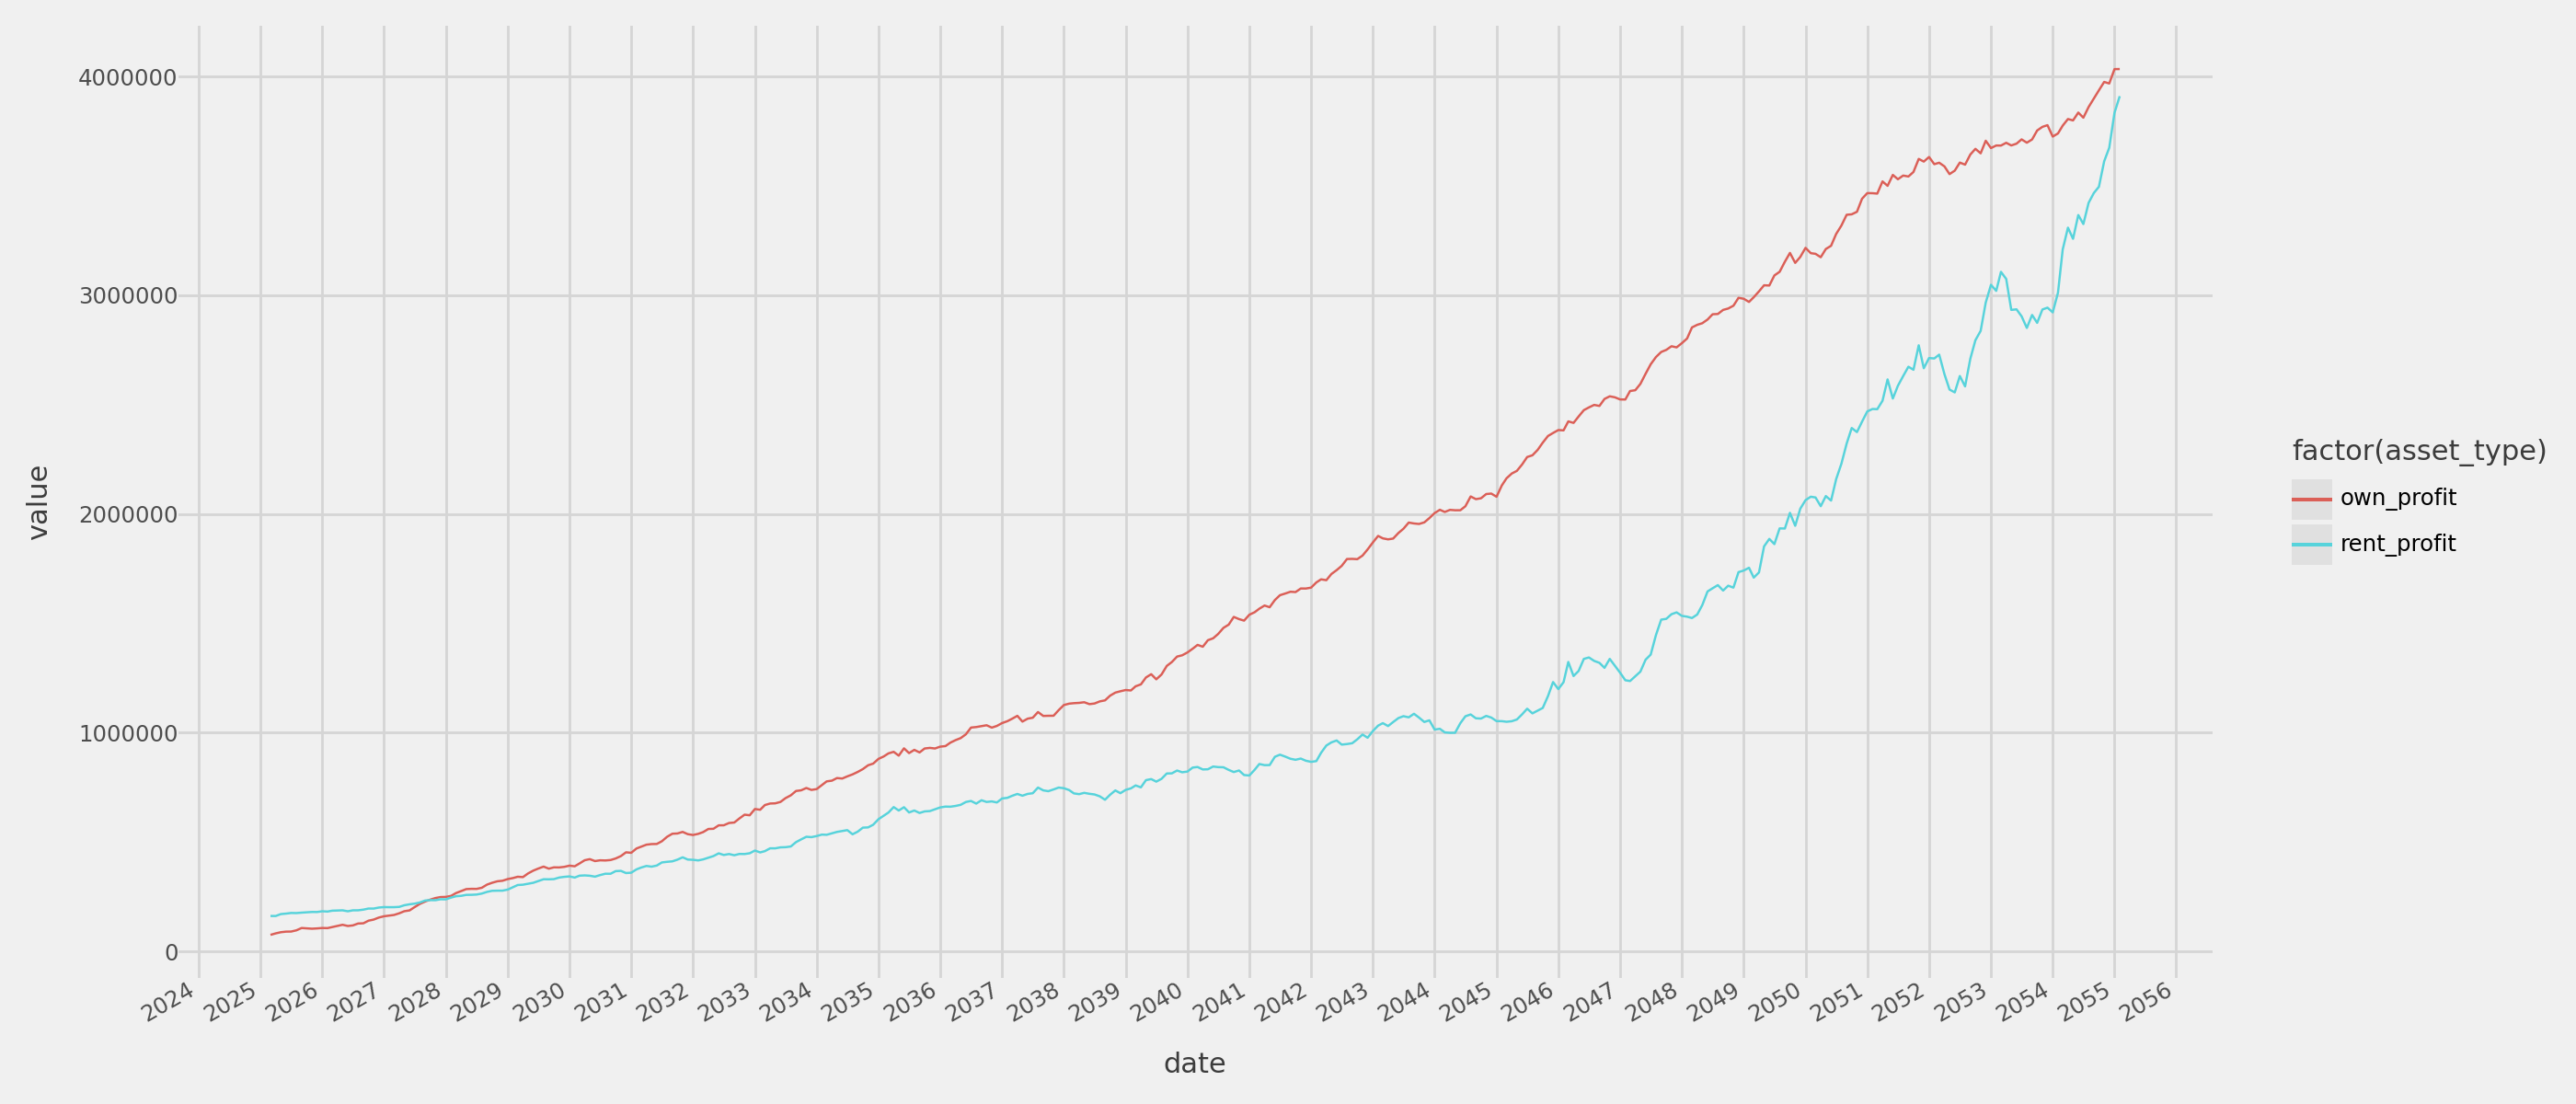

In [212]:
(
    ggplot(merged, aes("date", "value", color="factor(asset_type)"))
    + geom_line()
    + scale_x_datetime(breaks=date_breaks(width="1 years"), labels=date_format("%Y"))
    + theme_538()
    + theme(figure_size=(14, 6), axis_text_x=element_text(rotation=30, hjust=1))
)